In [1]:
from PIL import Image, ImageDraw
from re import M
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
from math import ceil, floor,  pi, sqrt
import scipy.ndimage
from pprint import pprint
import os

In [2]:
def showSample(imgs, title):
    plt.figure()
    for i, imNum in enumerate(np.linspace(0, len(imgs)-1, 4, dtype=int)):
        plt.subplot(2, 2, i+1)
        plt.imshow(imgs[imNum], cmap='gray')
    plt.suptitle(title)

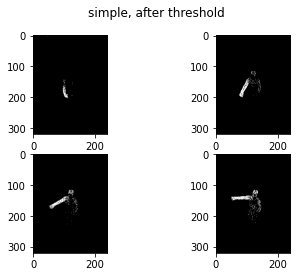

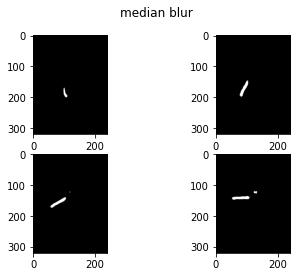

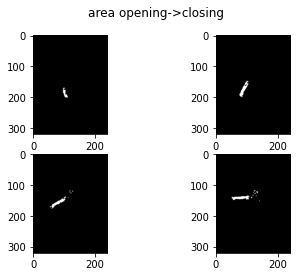

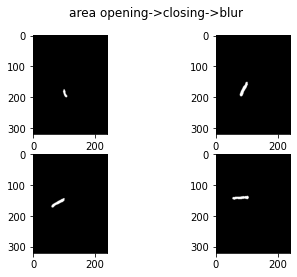

In [3]:
# 1.
imgs = []
for i in range(1, 23):
    name = f'./data/aerobic-{i:03}.bmp'
    imgs.append(np.array(rgb2gray(cv2.imread(name))))

diffs = []
for i in range(0, len(imgs) - 1):
    diffs.append(np.abs(imgs[i+1] - imgs[i]))

diffs = [d > 0.04 for d in diffs]
showSample(diffs, 'simple, after threshold')

T = 9
medBlur = []
for img in diffs:
    medBlur.append(cv2.medianBlur(img.astype(np.uint8), T))
showSample(medBlur, 'median blur')

open_close = []
for img in diffs:
    temp = scipy.ndimage.binary_opening(img, iterations=1) 
    temp = scipy.ndimage.binary_closing(temp, iterations=1) 
    open_close.append(temp)
showSample(open_close, 'area opening->closing')

open_close_blur = []
for img in diffs:
    temp = scipy.ndimage.binary_opening(img) 
    temp = scipy.ndimage.binary_closing(temp) 
    temp = cv2.medianBlur(temp.astype(np.uint8), T)
    open_close_blur.append(temp)
showSample(open_close_blur, 'area opening->closing->blur')

After finding the difference images, I tested various thresholds to convert the grayscale to a binary image. Keeping in mind that I would be using morphology later to further process the image and remove noise, I figured that it would be okay to leave a little bit of noise in, which will be removed by the later operations. I found that a threshold of 0.4 kept a large portion of the arm, with slight amounts of noise from the body moving around. 

First, I tested the median blur. I found that a threshold of 9 for the median blur filter worked well, removing a lot of the noise from the body. However, there were still some disconnected portions remaining, such as from the head.

Next I tested opening followed by closing. The python equivalent does not give an option for thresholding so there wasn't much testing to do other than changing the number of iterations of open/close. I found that more iterations reduced the amount of data too much, removing a lot of the white pixels. In this case, I found that a single iteration of opening followed by a single iteration of closing worked the best. 

While the major areas were filled in more, and less scattered from open/close, there was still a lot of noise leftover. To get rid of this noise, I decided to follow up with a round of median blurring. Opening followed by closing followed by blurring produced excellent results, with clearly defined regions and minimal (essentially none) noise. 

MEI similitude
[(0.06816516903713456, 'i=0, j=2'),
 (-0.0016661760471669582, 'i=0, j=3'),
 (0.020762092668245823, 'i=1, j=1'),
 (-0.003181922503441782, 'i=1, j=2'),
 (0.12007409184606133, 'i=2, j=0'),
 (0.007350538521353615, 'i=2, j=1'),
 (0.004409245433755165, 'i=3, j=0')]
MHI similitude
[(0.10966602226840892, 'i=0, j=2'),
 (0.004554671127072246, 'i=0, j=3'),
 (0.00024655045478564095, 'i=1, j=1'),
 (-0.012498587796780869, 'i=1, j=2'),
 (0.1617599204115548, 'i=2, j=0'),
 (0.012882825057225666, 'i=2, j=1'),
 (0.040615901307146526, 'i=3, j=0')]


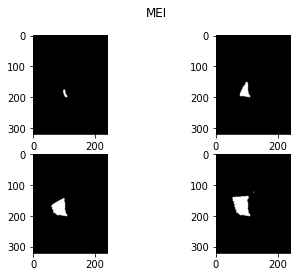

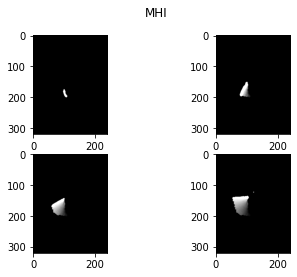

In [4]:
# 2.
def similitudeMoments(img):
    m_0_0 = calc_moment(img, 0, 0)
    x_bar = calc_moment(img, 1, 0) / m_0_0
    y_bar = calc_moment(img, 0, 1) / m_0_0
    nu = []
    for i in range(4):
        for j in range(4):
            if i+j >= 2 and i+j <= 3:
                nu.append(
                    (calc_moment(img, i, j, x_bar, y_bar) /
                     m_0_0**((i+j)/2+1), f'i={i}, j={j}')
                )
    return nu

def calc_moment(img, i, j, x_bar=0, y_bar=0):
    m = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            m += (x-x_bar)**i * (y-y_bar)**j * img[x][y]
    return m


# MEI
mei = np.copy(open_close_blur)
for i in range(len(mei)-1):
    img = mei[i]
    nextImg = mei[i+1]
    mei[i+1] = np.logical_or(img, nextImg)

showSample(mei, 'MEI')

# MHI
mhi = []
for i, img in enumerate(open_close_blur):
    tstamp = i + 2
    mhi.append(np.vectorize(lambda x: max(
        0.0, (tstamp-1.0)/21.0) if x else 0.0)(img))

for i in range(len(mhi)-1):
    img = mhi[i]
    nextImg = mhi[i+1]
    for x in range(len(img)):
        for y in range(len(img[x])):
            mhi[i+1][x][y] = max(img[x][y], nextImg[x][y])

showSample(mhi, 'MHI')

# calculate similitude moments
print('MEI similitude')
pprint(similitudeMoments(mei[-1]))
print('MHI similitude')
pprint(similitudeMoments(mhi[-1]))

The preprocessing from 1 helped to produce very clear MEI and MHI sequences. In both the MEI and MHI, only the arm was shown, except for a tiny speck of the head. Comparing the similitudes, the images seem very different. 

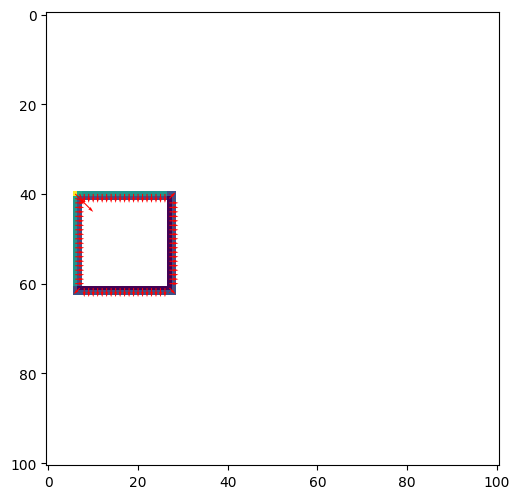

In [5]:
# 3.
box0 = np.zeros((101, 101))
box0[40:61, 6:27] = 255
box1 = np.zeros((101, 101))
box1[41:62, 7:28] = 255

Gx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]]) / 8
Gy = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]]) / 8

fx= cv2.filter2D(box1.astype(np.float32), -1, Gx)
fy= cv2.filter2D(box1.astype(np.float32), -1, Gy)
# fx = scipy.ndimage.correlate(box1, Gx, mode='nearest')
# fy = scipy.ndimage.correlate(box1, Gy, mode='nearest')

ft = box1 - box0
denom = np.nan_to_num(np.sqrt(fx**2+fy**2))
with np.errstate(divide='ignore', invalid='ignore'):
    mag = -ft / denom
    u = fx/denom * mag
    v = fy/denom * mag
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(mag)
dot = np.dot(u, mag)
plt.quiver(u, v, color='red', scale_units='xy', scale=1, angles='xy' )


The flow vectors on the sides were expected, but the corners were definitely interesting to see. The vectors on the top and bottom sides are going in the right direction (down), and similarly for the vectors on the left and right sides (right). This is easy to explain based on the strong transition of the image from white to black or vice versa, which shows up in the gradient, leading to the optic flow vector to point in that directionl. 

However, the corners are a different story. The top left and bottom right corners are going in the correct direction (bottom right), but the other two corner vectors are facing perpendicular to them. For example, at the bottom left corner, the gradient begins to 'combine' the two directions. Therefore, at the corner of the square there is an equal 'pull' in both directions, leading the slope of the gradient to point to either corner, depending on how you orient the gradient. I looked at the vectors before multiplying by the magnitude to see where they pointed originally, and found that the x-y combination pointed opposite of the final bottom left and top right vectors.

The orientation of the gradient is based on where the object was in the previous image. When moving to the bottom right, the top left and bottom right corners are moving 'into themselves', so there are pixels being subtracted when the object moves. However, the other two corners have small 'bite' taken out of the corner, where there is no data because the data is not continous (its 1px in this case). 
